## This notebook is a port of the training segment of donkeycar to fastai and pytorch.
C. Masenas 5SEP20

### This follows a regression model where the input is an `image` from a vehicle mounted camera and the target is a tensor containing float values for `throttle` and `steering`. 

In [1]:
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from PIL import ImageOps
# I think the following should be loaded by setup_book but sometimes that doesn't happen
from fastai.vision.all import *
from pandas.api.types import CategoricalDtype
from scipy.cluster import hierarchy as hc
import matplotlib as mpl

### The next cell creates a dataframe that can be read by fastai.  There is no need to create a python generator.  All that is done by fastai.

In [2]:
import os, json
import pandas as pd
from pathlib import Path

new_model_path = '/Users/cmasenas/mycar/models/newmodel'   # modify as necessary
path_to_json = '/Users/cmasenas/mycar/data/tub_4_20-01-20'  # color images are here
path = Path(path_to_json)
model_path = Path(new_model_path)


# Use list comprehension to get a list of json files in the directory
json_files = [file for file in os.listdir(path) if file.endswith('.json')]
json_files.remove("meta.json")  # no need for the meta file

# argument s is filename stored in json file, returns integer number for ordered images
def idx(s):  
    s = s.split('_')[1].split('.')[0]  # retrieve number in filename string for later sorting
    return int(s)

json_list = []  # create a list for contents of all json files in the directory path
for file in json_files:
    json_text = json.load(path/file) # read contents of each json file
    json_text.update({'num': idx(file)})  # add {key: value} pair to record number of the json file
    json_list.append(json_text) # append each json file content to a list
    
df = pd.DataFrame.from_records(json_list, exclude=['user/mode','milliseconds' ]) # create dataframe

df = df.rename(columns={"cam/image_array": "image", 
                        "user/throttle": "throttle", 
                        "user/angle": "steering"})
df = df.set_index('num') # number rows in order recorded
df = df.sort_index()   # put rows in order they were recorded
df = df[df.throttle > .7 ]  # keep data after initial acceleration
df.head()


,image,throttle,steering
num,,,
18,18_cam-image_array_.jpg,0.703604,0.000000
19,19_cam-image_array_.jpg,0.830073,0.000000
20,20_cam-image_array_.jpg,0.845882,0.000000
21,21_cam-image_array_.jpg,0.845882,-0.213477
22,22_cam-image_array_.jpg,0.845882,-0.419019


#### The data was taken going in one direction around the track.  A clockwise direction will have a majority of right turns.  Depending on your goal, it may be desirable to augment the data with opposite turns.  I wrote this transform to mirror a fraction of the images and the corresponding steering values to compensate.

#### My camera is aimed to pick up mostly the track so that surrounding objects are minimized.  I am hoping that this transform will allow me to navigate autonomously in the opposite direction to which it was trained.

In [3]:
class RandFlip(RandTransform):
    def __init__(self, p=1.0, **kwargs):
        super().__init__(p, **kwargs)
    def encodes(self, o: Tensor): 
        return Tensor([-o[0], o[1]])   # this reverses the target steering value
    def encodes(self, o: PILImage):
        return ImageOps.mirror(o)     # this mirrors the input image

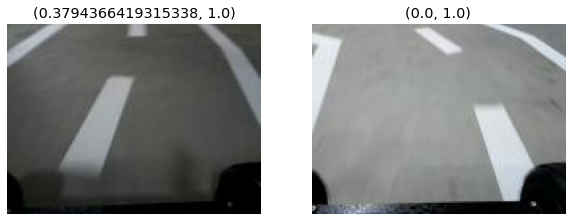

In [4]:
# https://docs.fast.ai/data.block#General-API
# https://docs.fast.ai/data.transforms#ColReader
nav = DataBlock(
    blocks=(ImageBlock(cls=PILImage) , RegressionBlock(n_out=2)),  # load color images
    get_x=ColReader('image', pref=path), 
    get_y=ColReader(['steering','throttle'])  ,
    splitter=IndexSplitter(valid_idx=list(range(int(len(df)*.2)))) ,
    item_tfms=[RandFlip(p=.5)]  # randomly mirror images and steering values

)
dls = nav.dataloaders(df, bs=256)
dls.show_batch(nrows=1,ncols=2,figsize=(10,10))
#nav.summary(df)

### Define the ML model

In [5]:
model = nn.Sequential(
        ConvLayer(3, 16, stride=2),
        ConvLayer(16, 32, stride=2),
        ConvLayer(32, 64, stride=2),
        ConvLayer(64, 128, stride=2),
        ConvLayer(128, 256, stride=2),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

#print(list(model.children()))
learn = Learner(dls, model,  loss_func = MSELossFlat(), metrics=[rmse], cbs=ActivationStats(with_hist=True))
#print(learn.summary())

0.19054607152938843 0.0012022644514217973


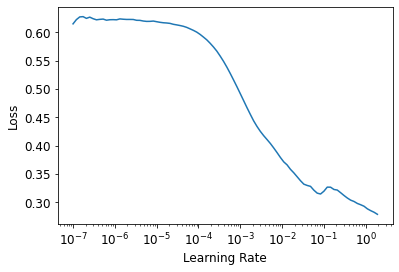

In [6]:
lr_min, lr_steep = learn.lr_find()
print(lr_min, lr_steep)

### Do the training using `fit_one_cycle`

In [7]:
learn.fit_one_cycle(10, 3e-3)  

epoch,train_loss,valid_loss,_rmse,time
0,0.383480,0.412670,0.642394,00:42
1,0.213422,0.254208,0.504191,00:43
2,0.142501,0.166639,0.408214,00:43
3,0.104609,0.065406,0.255745,00:43
4,0.081178,0.046493,0.215621,00:42
5,0.065213,0.035444,0.188266,00:40
6,0.054035,0.035864,0.189379,00:42
7,0.045896,0.039672,0.199177,00:42
8,0.039792,0.033280,0.182428,00:42
9,0.035187,0.032643,0.180672,00:41


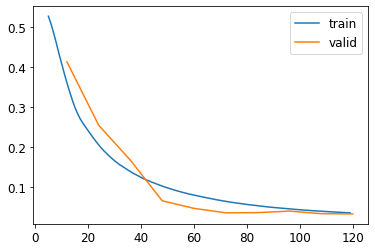

In [8]:
learn.recorder.plot_loss()

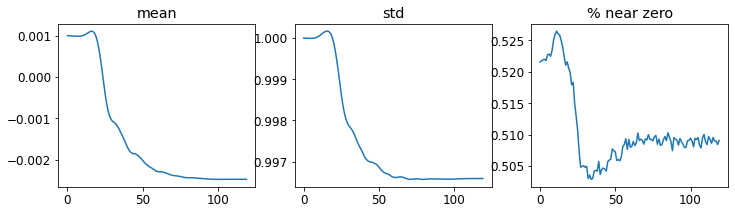

In [9]:
learn.activation_stats.plot_layer_stats(-2)

### Look at some output

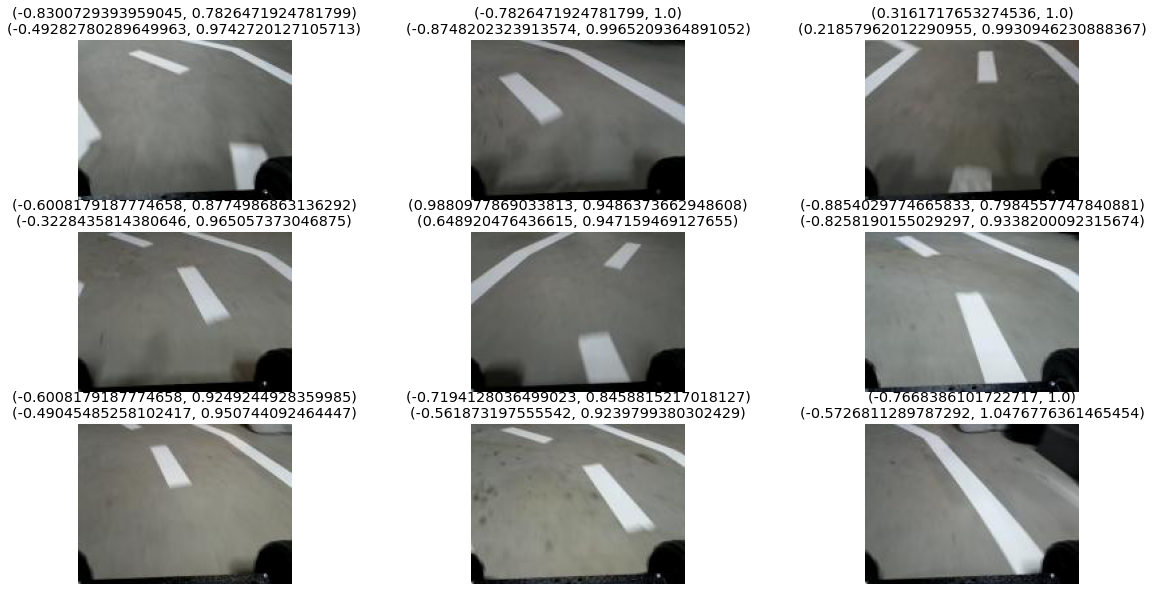

In [10]:
learn.show_results(figsize=(20,10))

In [11]:
dls=nav.dataloaders(df, bs=512)
preds, tgt = learn.get_preds(dl=[dls.one_batch()])

### The scattergram of target values vs predictions should yield points as close as possible to the red line.

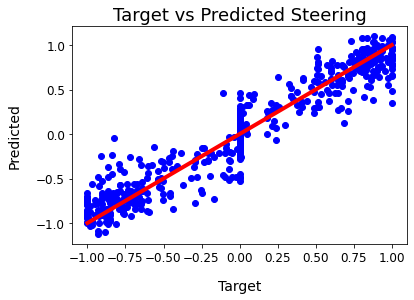

In [12]:
plt.title("Target vs Predicted Steering", fontsize=18, y=1.0)
plt.xlabel("Target", fontsize=14, labelpad=15)
plt.ylabel("Predicted", fontsize=14, labelpad=15)
plt.plot(tgt.T[0], preds.T[0],'bo')
plt.plot([-1,1],[-1,1],'r', linewidth = 4)
plt.show()


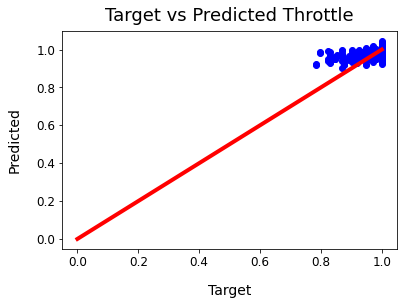

In [13]:
plt.title("Target vs Predicted Throttle", fontsize=18, y=1.02)
plt.xlabel("Target", fontsize=14, labelpad=15)
plt.ylabel("Predicted", fontsize=14, labelpad=15)
plt.plot(tgt.T[1], preds.T[1],'bo')
plt.plot([0,1],[0,1],'r', linewidth = 4)
plt.show()

In [14]:
learn.save(model_path)

Path('/Users/cmasenas/mycar/models/newmodel.pth')